**PREPARACION INICIAL DE LOS DATOS Y COMPROBACIÓN DE CARGA CORRECTA**


In [ ]:
import pandas as pd

# 1. Cargar datasets
ruta_plnt = "/content/df_procesado_PLNT.csv"
ruta_spy = "/content/df_spy_lstm.csv"

df_spy = pd.read_csv(ruta_spy, index_col=0, parse_dates=True)
df_plnt = pd.read_csv(ruta_plnt, index_col=0, parse_dates=True)

# 2. Limpiar nombres de columnas (eliminar espacios extra)
df_spy.columns = df_spy.columns.str.strip()
df_plnt.columns = df_plnt.columns.str.strip()

# 3. Convertir el índice en columna (si es necesario)
if "open" not in df_plnt.columns:
    df_plnt["open"] = df_plnt.index
    df_plnt.reset_index(drop=True, inplace=True)

# 4. Eliminar variables que podrían sesgar el modelo
df_spy = df_spy.drop(columns=["volatility"], errors="ignore")
df_spy = df_spy.drop(columns=["open_PLNT"], errors="ignore")
df_plnt = df_plnt.drop(columns=["open_SPY"], errors="ignore")

# 5. Filtrar columnas comunes para asegurar compatibilidad
columnas_comunes = [col for col in df_spy.columns if col in df_plnt.columns]
df_plnt = df_plnt[columnas_comunes]

columnas_comunes = [col for col in df_plnt.columns if col in df_spy.columns]
df_spy = df_spy[columnas_comunes]

# 6. Comprobación final
print("Columnas finales SPY:", df_spy.columns.tolist())
print("Columnas finales AAPL:", df_plnt.columns.tolist())

x = len(df_spy.columns)
y = len(df_plnt.columns)
print(x, y)

Columnas finales SPY: ['open', 'volume', 'News Sentiment', 'open_APPL', 'open_AMZN', 'open_AVGO', 'open_BRK.B', 'open_GOOGL', 'open_GOOG', 'open_META', 'open_MSFT', 'open_NVDA', 'open_TSLA', 'RSI', 'ema_long', 'MACD', 'MACD_signal', 'bollinger_mid', 'bollinger_std', 'ATR', 'daily_return', 'monthly_return', 'annual_return']
Columnas finales AAPL: ['open', 'volume', 'News Sentiment', 'open_APPL', 'open_AMZN', 'open_AVGO', 'open_BRK.B', 'open_GOOGL', 'open_GOOG', 'open_META', 'open_MSFT', 'open_NVDA', 'open_TSLA', 'RSI', 'ema_long', 'MACD', 'MACD_signal', 'bollinger_mid', 'bollinger_std', 'ATR', 'daily_return', 'monthly_return', 'annual_return']
23 23


**DEFINICION INICIAL DE FUNCIONES Y CUESTIONES INICIALES**


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Función para normalizar datos
def normalizar_datos(df):
    scaler = MinMaxScaler()
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
    return df_norm, scaler

# Función para crear secuencias de datos
def crear_secuencias(datos, n_pasos):
    X, y = [], []
    for i in range(n_pasos, len(datos)):
        X.append(datos.iloc[i - n_pasos:i].values)
        y.append(datos.iloc[i]["open"])
    return np.array(X), np.array(y)

# Función para construir modelo LSTM con Masking para ignorar los ceros
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Masking

def construir_gru(n_pasos, n_features):
    model = Sequential([
        Masking(mask_value=0.0, input_shape=(n_pasos, n_features)),  # Ignorar valores 0
        GRU(50, return_sequences=True),  # Primera capa GRU
        Dropout(0.2),
        GRU(50, return_sequences=False),  # Segunda capa GRU
        Dropout(0.2),
        Dense(25, activation="relu"),  # Capa densa intermedia
        Dense(1)  # Capa de salida para predicción
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

# Función para construir modelo LSTM con Masking para ignorar los ceros
def construir_lstm(n_pasos, n_features):
    model = Sequential([
        Masking(mask_value=0.0, input_shape=(n_pasos, n_features)),  # Ignorar valores 0
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation="relu"),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model


  # Crear el DataFrame vacío para almacenar las métricas
metricas = pd.DataFrame(columns=[
    'RMSE Sin TL',
    'RMSE Con TL',
    'RMSE Adj. Sin TL',
    'RMSE Adj. Con TL',
    'MAE Sin TL',
    'MAE Con TL',
    'R2 Sin TL',
    'R2 Con TL',
    'MAPE Sin TL',
    'MAPE Con TL',
    'Porcentaje Train Tesla',
    'Modelo (GRU / LSTM)','Años de datos',
    'Épocas modelo base',
    'Épocas fine-tuning',
    'Capas congeladas',
])

**PREDICCION BOOTSTRAP INTERVALS DEFINITION**

# **MODELO CON REGLAS ESTABLECIDAS DE HIPERPARÁMETROS**

Años de datos disponibles para PLNT: 8.40
Usando modelo LSTM (años de datos: 8.40 > 5)
Épocas para modelo base: 45
Épocas para fine-tuning: 34
Forma de X_spy: (3906, 60, 23)
Forma de X_plnt: (2055, 60, 23)
Construyendo modelo SPY con parámetros: n_pasos=60, n_features=23


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/45
245/245 ━━━━━━━━━━━━━━━━━━━━ 24s 74ms/step - loss: 0.0150
Epoch 2/45
245/245 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - loss: 0.0026
Epoch 3/45
245/245 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - loss: 0.0018
Epoch 4/45
245/245 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - loss: 0.0015
Epoch 5/45
245/245 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - loss: 0.0013
Epoch 6/45
245/245 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - loss: 9.9424e-04
Epoch 7/45
245/245 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - loss: 0.0011
Epoch 8/45
245/245 ━━━━━━━━━━━━━━━━━━━━ 22s 74ms/step - loss: 8.5266e-04
Epoch 9/45
245/245 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - loss: 9.0311e-04
Epoch 10/45
245/245 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - loss: 7.8920e-04
Epoch 11/45
245/245 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - loss: 6.5236e-04
Epoch 12/45
245/245 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - loss: 6.3447e-04
Epoch 13/45
245/245 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - loss: 5.9561e-04
Epoch 14/45
245/245 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - loss: 5.1707e-

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


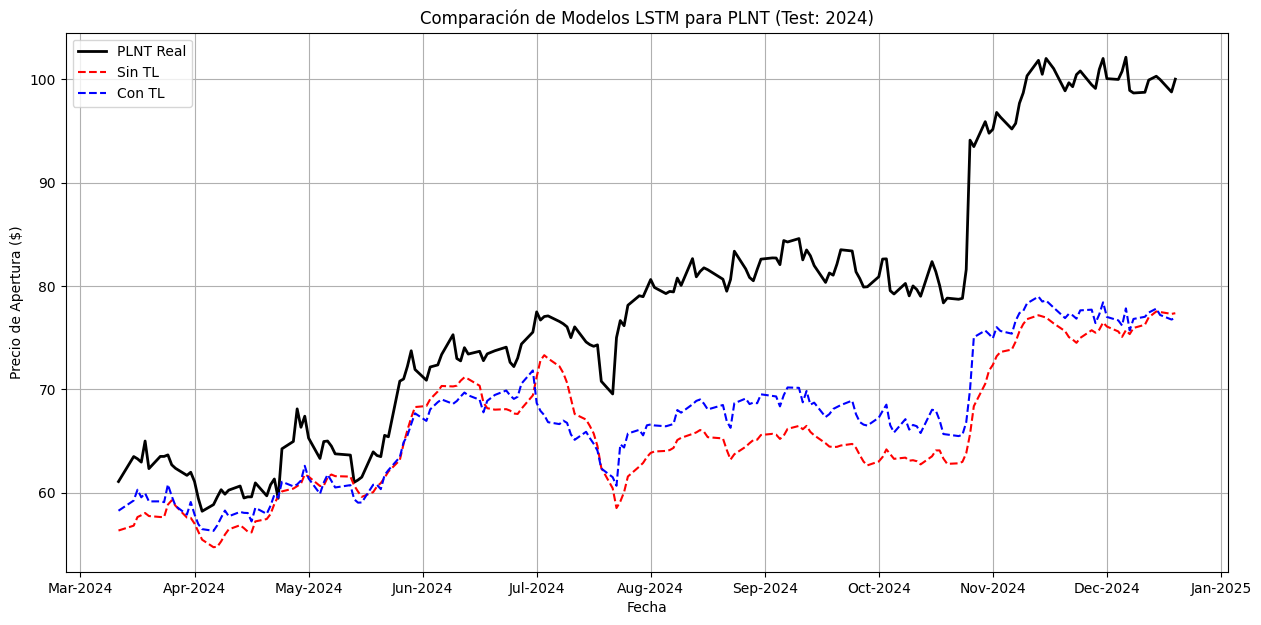


Comparación de métricas:
RMSE Sin TL: 14.74, Con TL: 12.98
RMSE Adj. Sin TL: 0.1887, Con TL: 0.1662
MAE Sin TL: 12.40, Con TL: 10.95
R2 Sin TL: -0.3806, Con TL: -0.0712
MAPE Sin TL: 14.79%, Con TL: 13.01%


<ipython-input-8-e3dedd9bf143>:305: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metricas = pd.concat([metricas, nuevas_metricas], ignore_index=False)


In [ ]:
from tensorflow.keras.layers import Masking
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import MinMaxScaler
from dateutil.relativedelta import relativedelta

# 1. CONFIGURACIÓN DE PARÁMETROS
año_entrenamiento = 2023
n_pasos = 60

# 2. DIVISIÓN DEL CONJUNTO DE DATOS
df_spy_train = df_spy[:f'2015-08-06']
df_plnt_train = df_plnt['2015-08-06':f'{año_entrenamiento}-12-31']

año_prueba = año_entrenamiento + 1
df_plnt_test = df_plnt[f'{año_prueba}-01-01':f'{año_prueba}-12-31']

# Cálculo dinámico de años de datos disponibles para PLNT
inicio_plnt = pd.to_datetime('2015-08-06')
fin_entrenamiento = pd.to_datetime(f'{año_entrenamiento}-12-31')
años_de_datos = (fin_entrenamiento - inicio_plnt).days / 365.25

print(f"Años de datos disponibles para PLNT: {años_de_datos:.2f}")

# Selección dinámica del tipo de modelo
if años_de_datos <= 5:
    print(f"Usando modelo GRU (años de datos: {años_de_datos:.2f} ≤ 5)")
    construir_modelo = construir_gru
    tipo_modelo = "GRU"
else:
    print(f"Usando modelo LSTM (años de datos: {años_de_datos:.2f} > 5)")
    construir_modelo = construir_lstm
    tipo_modelo = "LSTM"

# Cálculo dinámico de épocas
epocas_modelo_base = max(10, int(50 - (años_de_datos / 2)))
epocas_fine_tuning = min(100, int(30 + (años_de_datos / 2)))

print(f"Épocas para modelo base: {epocas_modelo_base}")
print(f"Épocas para fine-tuning: {epocas_fine_tuning}")

# 3. NORMALIZACIÓN DE DATOS
scaler_spy = MinMaxScaler()
df_spy_train_norm = pd.DataFrame(scaler_spy.fit_transform(df_spy_train), columns=df_spy.columns, index=df_spy_train.index)

scaler_plnt = MinMaxScaler()
df_plnt_train_norm = pd.DataFrame(scaler_plnt.fit_transform(df_plnt_train), columns=df_plnt.columns, index=df_plnt_train.index)

df_plnt_test_norm = pd.DataFrame(scaler_plnt.transform(df_plnt_test), columns=df_plnt.columns, index=df_plnt_test.index)

# 4. CREACIÓN DE SECUENCIAS DE DATOS PARA ENTRENAMIENTO
try:
    # Usar las funciones de creación de secuencias ya definidas
    X_spy, y_spy = crear_secuencias(df_spy_train_norm, n_pasos)
    X_plnt, y_plnt = crear_secuencias(df_plnt_train_norm, n_pasos)

    print(f"Forma de X_spy: {X_spy.shape}")
    print(f"Forma de X_plnt: {X_plnt.shape}")

    # Verificar que las dimensiones sean correctas
    if len(X_spy.shape) < 3 or X_spy.shape[0] == 0:
        raise ValueError("No hay suficientes datos en SPY para crear secuencias válidas")

    if len(X_plnt.shape) < 3 or X_plnt.shape[0] == 0:
        raise ValueError("No hay suficientes datos en PLNT para crear secuencias válidas")

    # Obtener el número de características
    n_features_spy = X_spy.shape[2]
    n_features_plnt = X_plnt.shape[2]

except Exception as e:
    print(f"Error al crear secuencias: {e}")
    # Crear datos de forma manual si hay un problema
    if len(df_spy_train_norm) > n_pasos and len(df_plnt_train_norm) > n_pasos:
        # Construir manualmente las secuencias
        X_spy = np.array([df_spy_train_norm.values[i:i+n_pasos] for i in range(len(df_spy_train_norm)-n_pasos)])
        y_spy = np.array([df_spy_train_norm.values[i+n_pasos, 0] for i in range(len(df_spy_train_norm)-n_pasos)])

        X_plnt = np.array([df_plnt_train_norm.values[i:i+n_pasos] for i in range(len(df_plnt_train_norm)-n_pasos)])
        y_plnt = np.array([df_plnt_train_norm.values[i+n_pasos, 0] for i in range(len(df_plnt_train_norm)-n_pasos)])

        print(f"Secuencias creadas manualmente. X_spy: {X_spy.shape}, X_plnt: {X_plnt.shape}")

        n_features_spy = X_spy.shape[2] if len(X_spy.shape) == 3 else df_spy_train_norm.shape[1]
        n_features_plnt = X_plnt.shape[2] if len(X_plnt.shape) == 3 else df_plnt_train_norm.shape[1]
    else:
        print("No hay suficientes datos para crear secuencias")
        n_features_spy = df_spy_train_norm.shape[1]
        n_features_plnt = df_plnt_train_norm.shape[1]
        X_spy = np.zeros((1, n_pasos, n_features_spy))
        y_spy = np.zeros(1)
        X_plnt = np.zeros((1, n_pasos, n_features_plnt))
        y_plnt = np.zeros(1)

# 5. CONSTRUCCIÓN Y ENTRENAMIENTO DE MODELOS
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Modelo base SPY
try:
    print(f"Construyendo modelo SPY con parámetros: n_pasos={n_pasos}, n_features={n_features_spy}")
    modelo_spy = construir_modelo(n_pasos, n_features_spy)
    modelo_spy.fit(X_spy, y_spy, epochs=epocas_modelo_base, batch_size=16, verbose=1, callbacks=[early_stopping])
except Exception as e:
    print(f"Error al construir/entrenar modelo SPY: {e}")
    # Si falla, crear un modelo más simple
    modelo_spy = Sequential([
        Masking(mask_value=0.0, input_shape=(n_pasos, n_features_spy)),
        LSTM(32),
        Dense(1)
    ])
    modelo_spy.compile(optimizer="adam", loss="mse")
    print("Creado modelo SPY de respaldo")

# Modelo PLNT sin transfer learning
try:
    print(f"Construyendo modelo PLNT con parámetros: n_pasos={n_pasos}, n_features={n_features_plnt}")
    modelo_plnt = construir_modelo(n_pasos, n_features_plnt)
    modelo_plnt.fit(X_plnt, y_plnt, epochs=50, batch_size=16, verbose=1, callbacks=[early_stopping])
except Exception as e:
    print(f"Error al construir/entrenar modelo PLNT: {e}")
    # Si falla, crear un modelo más simple
    modelo_plnt = Sequential([
        Masking(mask_value=0.0, input_shape=(n_pasos, n_features_plnt)),
        LSTM(32),
        Dense(1)
    ])
    modelo_plnt.compile(optimizer="adam", loss="mse")
    print("Creado modelo PLNT de respaldo")

# 6. TRANSFER LEARNING: AFINAR MODELO SPY CON PLNT
try:
    modelo_spy_tuned = tf.keras.models.clone_model(modelo_spy)
    modelo_spy_tuned.set_weights(modelo_spy.get_weights())

    # Cálculo dinámico de capas a congelar
    total_capas_entrenables = len([layer for layer in modelo_spy_tuned.layers if len(layer.weights) > 0])
    capas_a_congelar = max(0, int(total_capas_entrenables - (años_de_datos / 2)))

    print(f"Total de capas entrenables: {total_capas_entrenables}")
    print(f"Capas a congelar: {capas_a_congelar}")

    # Congelar capas según la fórmula
    capas_congeladas = 0
    for layer in modelo_spy_tuned.layers:
        if len(layer.weights) > 0:  # Solo considerar capas con pesos
            if capas_congeladas < capas_a_congelar:
                layer.trainable = False
                capas_congeladas += 1
                print(f"Capa {layer.name} congelada")
            else:
                layer.trainable = True
                print(f"Capa {layer.name} entrenable")

    modelo_spy_tuned.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss="mse")
    modelo_spy_tuned.fit(X_plnt, y_plnt, epochs=epocas_fine_tuning, batch_size=16, verbose=1, callbacks=[early_stopping])
except Exception as e:
    print(f"Error en transfer learning: {e}")
    modelo_spy_tuned = modelo_plnt  # Usar el modelo no transferido como respaldo
    capas_a_congelar = 0

# 7. PREDICCIONES EN DATOS DE TEST
try:
    X_test, y_test = crear_secuencias(df_plnt_test_norm, n_pasos)
    print(f"Forma de X_test: {X_test.shape}")
except Exception as e:
    print(f"Error al crear secuencias de test: {e}")
    # Crear manualmente
    if len(df_plnt_test_norm) > n_pasos:
        X_test = np.array([df_plnt_test_norm.values[i:i+n_pasos] for i in range(len(df_plnt_test_norm)-n_pasos)])
        y_test = np.array([df_plnt_test_norm.values[i+n_pasos, 0] for i in range(len(df_plnt_test_norm)-n_pasos)])
    else:
        print("No hay suficientes datos de test")
        # Crear datos vacíos para evitar errores
        X_test = np.zeros((1, n_pasos, df_plnt_test_norm.shape[1]))
        y_test = np.zeros(1)

try:
    pred_sin_tl = modelo_plnt.predict(X_test)
    pred_con_tl = modelo_spy_tuned.predict(X_test)
except Exception as e:
    print(f"Error al hacer predicciones: {e}")
    # Crear predicciones ficticias
    pred_sin_tl = np.zeros((len(y_test), 1))
    pred_con_tl = np.zeros((len(y_test), 1))

# 8. DESNORMALIZACIÓN DE PREDICCIONES
try:
    # Crear arrays completos para desnormalizar
    y_test_array = np.zeros((y_test.shape[0], df_plnt.shape[1]))
    y_test_array[:, 0] = y_test  # La primera columna es 'open'

    pred_sin_tl_array = np.zeros((pred_sin_tl.shape[0], df_plnt.shape[1]))
    pred_sin_tl_array[:, 0] = pred_sin_tl.flatten()

    pred_con_tl_array = np.zeros((pred_con_tl.shape[0], df_plnt.shape[1]))
    pred_con_tl_array[:, 0] = pred_con_tl.flatten()

    # Desnormalizar
    y_test_real = scaler_plnt.inverse_transform(y_test_array)[:, 0]
    pred_sin_tl_real = scaler_plnt.inverse_transform(pred_sin_tl_array)[:, 0]
    pred_con_tl_real = scaler_plnt.inverse_transform(pred_con_tl_array)[:, 0]

except Exception as e:
    print(f"Error al desnormalizar: {e}")

    try:
        # Método alternativo de respaldo
        y_test_reshape = y_test.reshape(-1, 1)
        empty_data = np.zeros((y_test.shape[0], df_plnt.shape[1] - 1))
        y_test_full = np.hstack([y_test_reshape, empty_data])
        y_test_real = scaler_plnt.inverse_transform(y_test_full)[:, 0]

        pred_sin_tl_reshape = pred_sin_tl.reshape(-1, 1)
        pred_sin_tl_full = np.hstack([pred_sin_tl_reshape, empty_data])
        pred_sin_tl_real = scaler_plnt.inverse_transform(pred_sin_tl_full)[:, 0]

        pred_con_tl_reshape = pred_con_tl.reshape(-1, 1)
        pred_con_tl_full = np.hstack([pred_con_tl_reshape, empty_data])
        pred_con_tl_real = scaler_plnt.inverse_transform(pred_con_tl_full)[:, 0]
    except:
        # Si todo falla, usar valores sin transformar
        print("Usando valores sin desnormalizar para las métricas")
        y_test_real = y_test
        pred_sin_tl_real = pred_sin_tl.flatten()
        pred_con_tl_real = pred_con_tl.flatten()

# 9. CÁLCULO DE MÉTRICAS DE ERROR
try:
    rmse_sin_tl = np.sqrt(mean_squared_error(y_test_real, pred_sin_tl_real))
    rmse_con_tl = np.sqrt(mean_squared_error(y_test_real, pred_con_tl_real))

    rmse_adj_sin_tl = rmse_sin_tl / np.average(y_test_real) if np.average(y_test_real) != 0 else 0
    rmse_adj_con_tl = rmse_con_tl / np.average(y_test_real) if np.average(y_test_real) != 0 else 0

    mae_sin_tl = mean_absolute_error(y_test_real, pred_sin_tl_real)
    mae_con_tl = mean_absolute_error(y_test_real, pred_con_tl_real)

    r2_sin_tl = r2_score(y_test_real, pred_sin_tl_real)
    r2_con_tl = r2_score(y_test_real, pred_con_tl_real)

    # Evitar división por cero en MAPE
    epsilon = 1e-10  # Pequeño valor para evitar división por cero
    y_test_real_safe = np.where(y_test_real == 0, epsilon, y_test_real)
    mape_sin_tl = np.mean(np.abs((y_test_real - pred_sin_tl_real) / y_test_real_safe)) * 100
    mape_con_tl = np.mean(np.abs((y_test_real - pred_con_tl_real) / y_test_real_safe)) * 100
except Exception as e:
    print(f"Error al calcular métricas: {e}")
    # Valores predeterminados
    rmse_sin_tl = rmse_con_tl = rmse_adj_sin_tl = rmse_adj_con_tl = 0
    mae_sin_tl = mae_con_tl = mape_sin_tl = mape_con_tl = 0
    r2_sin_tl = r2_con_tl = 0

# 10. GRÁFICO DE COMPARACIÓN DE MODELOS
try:
    plt.figure(figsize=(15, 7))
    plt.plot(df_plnt_test.iloc[n_pasos:].index[:len(y_test_real)], y_test_real, label="PLNT Real", color="black", linewidth=2)
    plt.plot(df_plnt_test.iloc[n_pasos:].index[:len(pred_sin_tl_real)], pred_sin_tl_real, label="Sin TL", color="red", linestyle="dashed")
    plt.plot(df_plnt_test.iloc[n_pasos:].index[:len(pred_con_tl_real)], pred_con_tl_real, label="Con TL", color="blue", linestyle="dashed")
    plt.title(f"Comparación de Modelos {tipo_modelo} para PLNT (Test: {año_entrenamiento+1})")
    plt.xlabel("Fecha")
    plt.ylabel("Precio de Apertura ($)")
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(30))
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%b-%Y"))
    plt.legend()
    plt.grid(True)
    plt.show()
except Exception as e:
    print(f"Error al crear gráfico: {e}")

# 11. ALMACENAR MÉTRICAS EN UN DATAFRAME
try:
    porcentaje_train_plnt = len(df_plnt_train) / len(df_plnt) * 100

    nuevas_metricas = pd.DataFrame({
        'RMSE Sin TL': [rmse_sin_tl],
        'RMSE Con TL': [rmse_con_tl],
        'RMSE Adj. Sin TL': [rmse_adj_sin_tl],
        'RMSE Adj. Con TL': [rmse_adj_con_tl],
        'MAE Sin TL': [mae_sin_tl],
        'MAE Con TL': [mae_con_tl],
        'R2 Sin TL': [r2_sin_tl],
        'R2 Con TL': [r2_con_tl],
        'MAPE Sin TL': [mape_sin_tl],
        'MAPE Con TL': [mape_con_tl],
        'Porcentaje Train PLNT': [porcentaje_train_plnt],
        'Modelo (GRU / LSTM)': [tipo_modelo],
        'Años de datos': [años_de_datos],
        'Épocas modelo base': [epocas_modelo_base],
        'Épocas fine-tuning': [epocas_fine_tuning],
        'Capas congeladas': [capas_a_congelar]
    }, index=[f'Año {año_entrenamiento}+{1}'])

    # Cambiar "Tesla" por "PLNT" en las columnas de metricas
    metricas_cols = list(metricas.columns)
    if 'Porcentaje Train Tesla' in metricas_cols:
        # Crear un diccionario para renombrar columnas
        rename_dict = {'Porcentaje Train Tesla': 'Porcentaje Train PLNT'}
        metricas = metricas.rename(columns=rename_dict)

    # Concatenar con el DataFrame de métricas existente
    metricas = pd.concat([metricas, nuevas_metricas], ignore_index=False)

except Exception as e:
    print(f"Error al almacenar métricas: {e}")

# Mostrar las métricas
print("\nComparación de métricas:")
print(f"RMSE Sin TL: {rmse_sin_tl:.2f}, Con TL: {rmse_con_tl:.2f}")
print(f"RMSE Adj. Sin TL: {rmse_adj_sin_tl:.4f}, Con TL: {rmse_adj_con_tl:.4f}")
print(f"MAE Sin TL: {mae_sin_tl:.2f}, Con TL: {mae_con_tl:.2f}")
print(f"R2 Sin TL: {r2_sin_tl:.4f}, Con TL: {r2_con_tl:.4f}")
print(f"MAPE Sin TL: {mape_sin_tl:.2f}%, Con TL: {mape_con_tl:.2f}%")

In [ ]:
metricas

,RMSE Sin TL,RMSE Con TL,RMSE Adj. Sin TL,RMSE Adj. Con TL,MAE Sin TL,MAE Con TL,R2 Sin TL,R2 Con TL,MAPE Sin TL,MAPE Con TL,Porcentaje Train PLNT,Modelo (GRU / LSTM),Años de datos,Épocas modelo base,Épocas fine-tuning,Capas congeladas
Año 2023+1,14.735295,12.979465,0.188727,0.166238,12.39815,10.950134,-0.38063,-0.071206,14.786509,13.0097,89.353612,LSTM,8.402464,45,34,0


In [ ]:

# Apply round function to all numeric columns in the 'metricas' DataFrame
metricas = metricas.round(2)
